In [148]:
# Load packages as usual
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import matplotlib.cm as cm
import numpy.matlib
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Manipulating figure sizes
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,7)
matplotlib.rc('font', size=15)
matplotlib.rc('axes', titlesize=15)

In [149]:
def __read(fileName, pTrainSamples = 0.6, pValidSamples = 0.2):
    emp_df = pd.read_csv(fileName)
    values = emp_df.values
    # Changed from np.float
    values = emp_df.values.astype(float)
    
    nTrainSamples = int(values.shape[0] * pTrainSamples)
    nValidSamples = int(values.shape[0] * pValidSamples)
    
    trainingFeatures = values[0:nTrainSamples, 0:-1]
    trainingLabels   = values[0:nTrainSamples, -1]
    validationFeatures = values[nTrainSamples:nTrainSamples + nValidSamples, 0:-1]
    validationLabels   = values[nTrainSamples:nTrainSamples + nValidSamples, -1]
    testingFeatures    = values[nTrainSamples + nValidSamples:, 0:-1]
    testingLabels      = values[nTrainSamples + nValidSamples:, -1]
    # Changed from np.float and np.int
    return trainingFeatures.astype(float), trainingLabels.astype(int), \
           validationFeatures.astype(float), validationLabels.astype(int), \
           testingFeatures.astype(float), testingLabels.astype(int)


trainingFeatures, trainingLabels, validationFeatures, validationLabels, testingFeatures, testingLabels = __read('./iris_new.csv')
print('shape training = ', trainingFeatures.shape)
print('shape validation = ', validationFeatures.shape)
print('shape testing = ', testingFeatures.shape)

shape training =  (88, 4)
shape validation =  (29, 4)
shape testing =  (31, 4)


In [150]:
def __PCA(data):
    data = data.T # Transpose the data so that each row is a feature (this was the format of the data in the previous assigment)
    
    # Normalize the data
    mean = np.mean(data, 1) # Compute the mean of the data
    mean_cols = np.matlib.repmat(mean, data.shape[1], 1).T # Repeat the mean across columns (so that it can be subtracted from each data point)
    data_cent = data - mean_cols # Center the data

    # Compute the covariance matrix
    covar = np.cov(data_cent)

    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigVals, eigVecs = np.linalg.eigh(covar) # Returned in ascending order
    
    # Reverse the order of the eigenvalues and eigenvectors so that they are in decreasing order
    PCevals = np.flip(eigVals) # Reverse the order of the eigenvalues
    PCevecs = np.flip(eigVecs, 1) # Reverse the order of the eigenvectors (columns)
    
    chosen_features = np.argmax(np.abs(PCevecs[:, :2]), axis=0)
    return PCevals, PCevecs


def __transformData(features, PCevecs):
    return np.dot(features,  PCevecs[:, 0:2])


PCevals, PCevecs = __PCA(trainingFeatures)
trainingFeatures2D = __transformData(trainingFeatures, PCevecs)
validationFeatures2D = __transformData(validationFeatures, PCevecs)
testingFeatures2D = __transformData(testingFeatures, PCevecs)
print('shape training = ', trainingFeatures2D.shape)
print('shape validation = ', validationFeatures2D.shape)
print('shape testing = ', testingFeatures2D.shape)
print('explained variance = ', np.sum(PCevals[0:2])/np.sum(PCevals))

shape training =  (88, 2)
shape validation =  (29, 2)
shape testing =  (31, 2)
explained variance =  0.9767350808869706


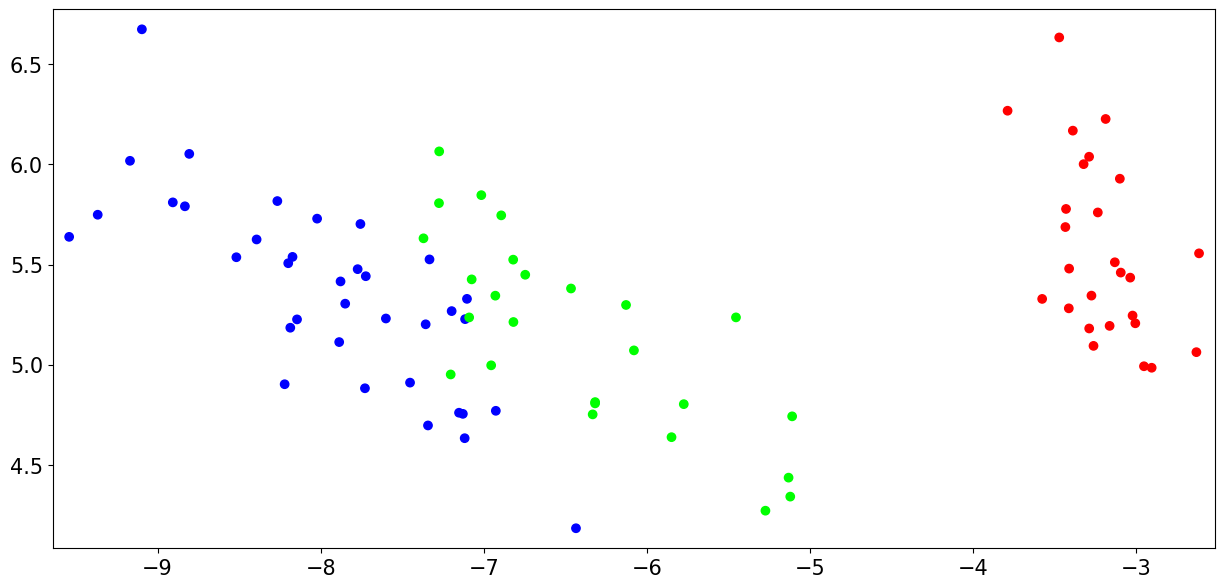

In [151]:
def __visualizeLabels(features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    y = referenceLabels

    plt.scatter(features[:, 0], features[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(features[:, 0].min() - 0.1, features[:, 0].max() + 0.1)
    plt.ylim(features[:, 1].min() - 0.1, features[:, 1].max() + 0.1)
    plt.savefig('1a.png')
    plt.show()
    t = 0
    
__visualizeLabels(trainingFeatures2D, trainingLabels)

accuracy (n =  1 ) =  0.9310344827586207
accuracy (n =  2 ) =  0.9655172413793104
accuracy (n =  3 ) =  1.0
accuracy (n =  4 ) =  1.0
accuracy (n =  5 ) =  1.0


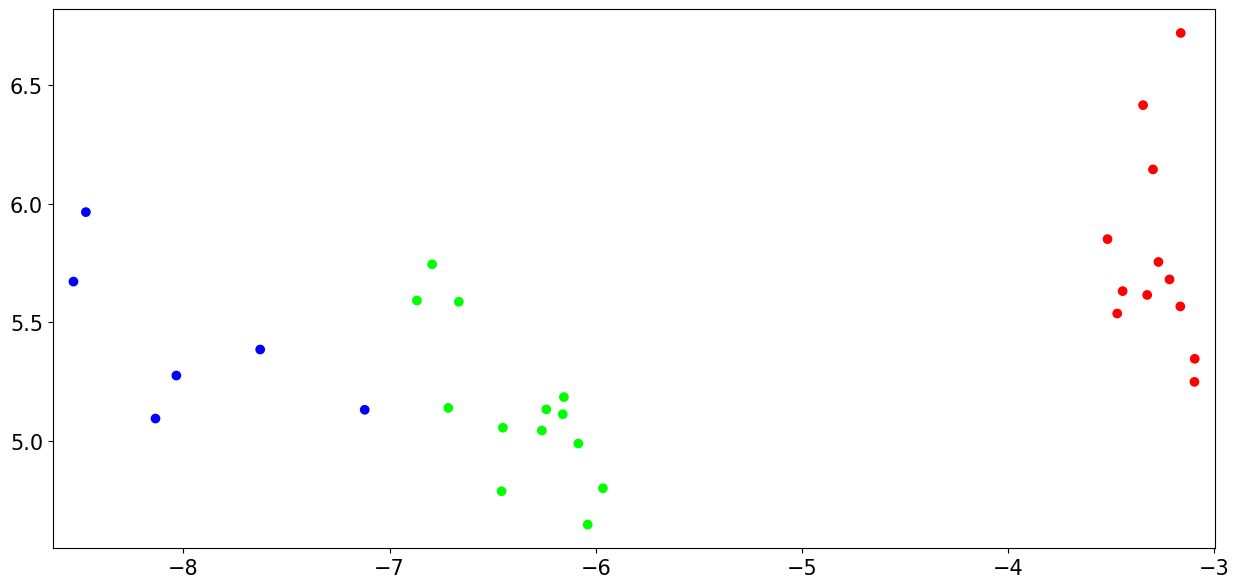

1.0

In [152]:
def __kNNTest(trainingFeatures2D, trainingLabels, n_neighbors, validationFeatures2D, validationLabels, plot = False):
    predictions = []
    for validationFeature in validationFeatures2D:
        # Calcualte euclidean distances and sort them
        distances = np.sqrt(np.sum((trainingFeatures2D - validationFeature)**2, axis=1))
        sortedIndex = np.argsort(distances)

        # Take the n first labels
        closestLabels = trainingLabels[sortedIndex[0:n_neighbors]]
        
        # Get the most common label (bincount returns the number of occurences of each label)
        prediction = np.argmax(np.bincount(closestLabels))
        predictions.append(prediction)
    
    if(plot):
        __visualizeLabels(validationFeatures2D, predictions)

    accuracy = np.sum(predictions == validationLabels) / len(validationLabels)
    return accuracy



# Best to pick 3 or 5 as both are odd numbers and have a good accuracy (100%)
for n in range(1, 6):
    print('accuracy (n = ', n, ') = ', __kNNTest(trainingFeatures2D, trainingLabels, n, validationFeatures2D, validationLabels))

__kNNTest(trainingFeatures2D, trainingLabels, 5, testingFeatures2D, testingLabels, True)


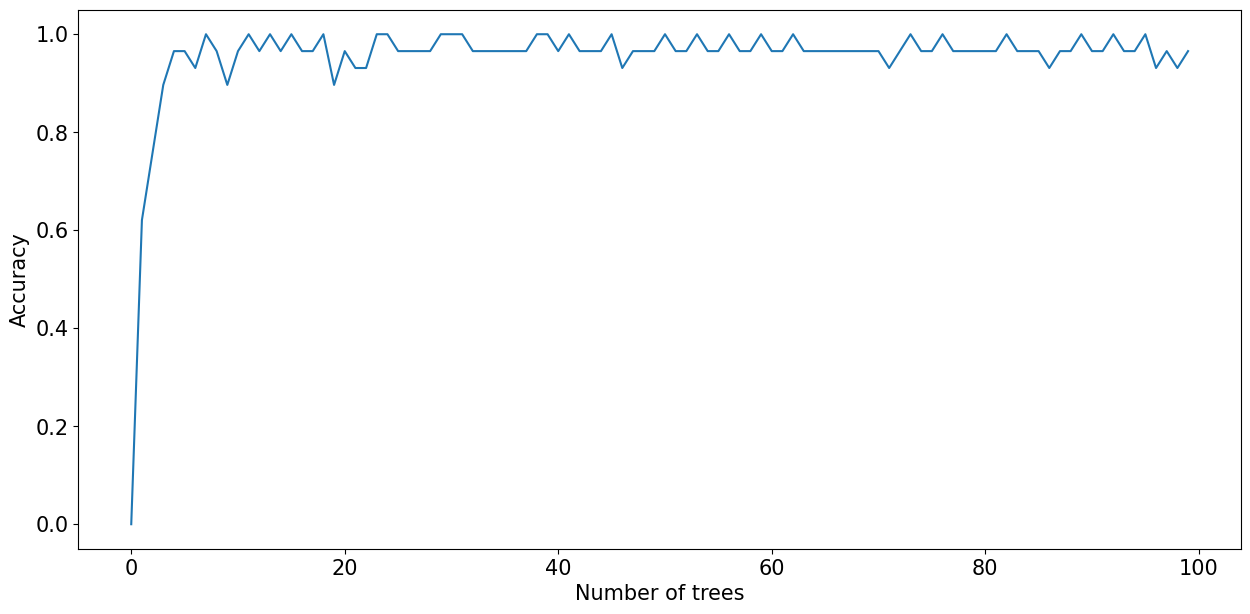

accuracy (n =  7 ) =  1.0
accuracy (n =  11 ) =  1.0
accuracy (n =  13 ) =  1.0
accuracy (n =  15 ) =  1.0
accuracy (n =  18 ) =  1.0
accuracy (n =  23 ) =  1.0
accuracy (n =  24 ) =  1.0
accuracy (n =  29 ) =  1.0


In [153]:
def __randomForests(trainingFeatures2D, trainingLabels, n_trees = 100):
    # We can use entropy as the data set is not very large, we let the trees grow to the maximum depth. To save computation time we can limit the number of trees after testing.
    predictor = RandomForestClassifier(n_estimators=n_trees)
    predictor.fit(trainingFeatures2D, trainingLabels)
    return predictor


accuracy_list = np.array([0])
for n in range(1, 100):
    predictor = __randomForests(trainingFeatures2D, trainingLabels, n)
    predictions = predictor.predict(validationFeatures2D)
    accuracy = np.sum(predictions == validationLabels) / len(validationLabels)
    
    accuracy_list = np.append(accuracy_list, accuracy)
    
plt.figure()
plt.plot(accuracy_list)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.savefig('1d.png')
plt.show()

for n in range(1, 30):
    if(accuracy_list[n] == accuracy_list.max()):
        print('accuracy (n = ', n, ') = ', accuracy_list.max())


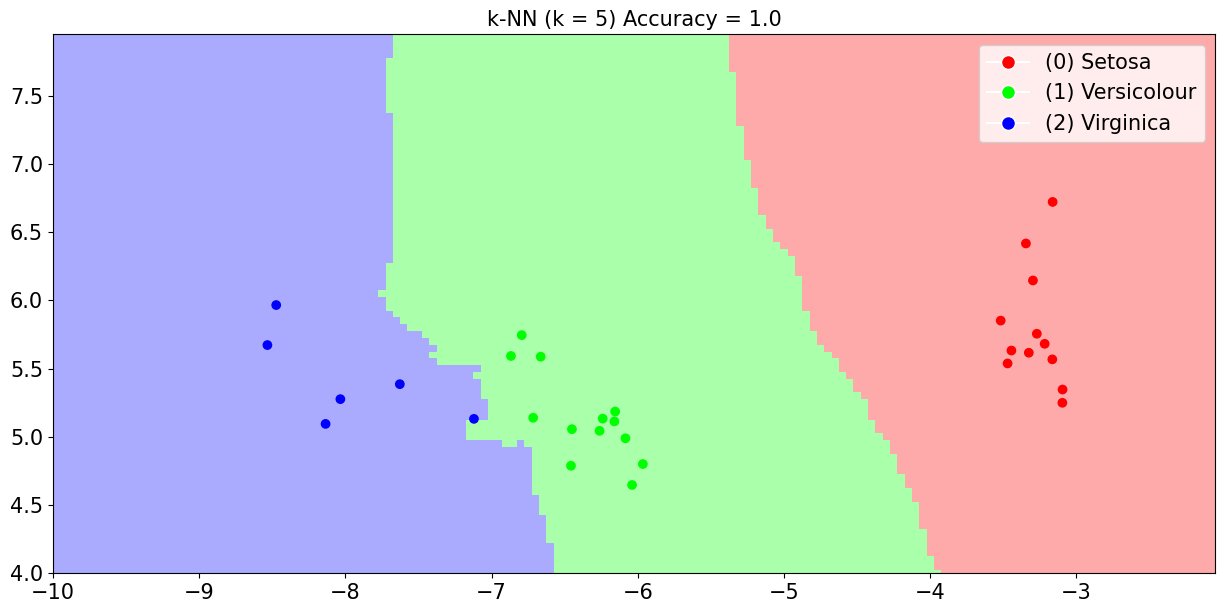

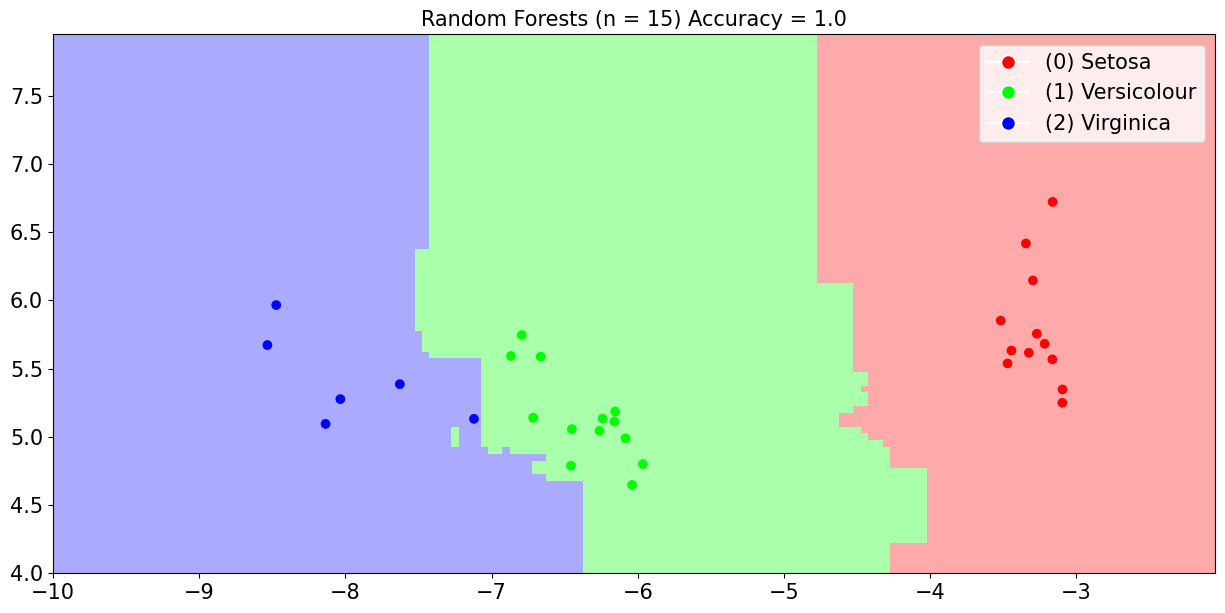

In [156]:
from matplotlib.lines import Line2D

def __kNN(trainingFeatures2D, trainingLabels, n_neighbors):
    predictor = KNeighborsClassifier(n_neighbors=n_neighbors)
    predictor.fit(trainingFeatures2D, trainingLabels)
    return predictor

def __visualizePredictions(predictor, features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    h = 0.05
    y = referenceLabels
    
    # x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    # y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    # xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
    #                      np.arange(y_min, y_max, h))
    # Z = predictor.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = Z.reshape(xx.shape)

    x0 = features[:, 0]
    x1 = features[:, 1]

    x0_min, x0_max = np.round(x0.min())-1, np.round(x0.max()+1)
    x1_min, x1_max = np.round(x1.min())-1, np.round(x1.max()+1)

    x0_axis_range = np.arange(x0_min,x0_max, h)
    x1_axis_range = np.arange(x1_min,x1_max, h)

    xx, yy = np.meshgrid(x0_axis_range, x1_axis_range)

    Z = predictor.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) # Reshape the predictions to the meshgrid shape
    
    plt.pcolormesh(xx, yy, Z, cmap = cmap_light)
    # Plot also the training points
    plt.scatter(features[:, 0], features[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    # Add legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='(0) Setosa', markerfacecolor='#FF0000', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='(1) Versicolour', markerfacecolor='#00FF00', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='(2) Virginica', markerfacecolor='#0000FF', markersize=10)]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add title depending on the predictor
    if isinstance(predictor, KNeighborsClassifier):
        plt.title('k-NN (k = ' + str(predictor.n_neighbors) + ')' + ' Accuracy = ' + str(np.sum(predictor.predict(features) == y) / len(y)))
        plt.savefig('1e1.png')
    elif isinstance(predictor, RandomForestClassifier):
        plt.title('Random Forests (n = ' + str(predictor.n_estimators) + ')' + ' Accuracy = ' + str(np.sum(predictor.predict(features) == y) / len(y)))
        plt.savefig('1e2.png')

    plt.show()

k = 5
n_trees = 15
kNNPredictor = __kNN(trainingFeatures2D, trainingLabels, k)
RFPredictor  = __randomForests(trainingFeatures2D, trainingLabels, n_trees)
__visualizePredictions(kNNPredictor, testingFeatures2D, testingLabels)
__visualizePredictions(RFPredictor, testingFeatures2D, testingLabels)